In [38]:
library(CellChat)
library(Seurat)
library(Matrix)
library(dplyr)
library(tidyverse)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

Attaching SeuratObject

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode



Rows: 3,249
Columns: 28
$ interaction_name         <chr> "TGFB1_TGFBR1_TGFBR2", "TGFB2_TGFBR1_TGFBR2",…
$ pathway_name             <chr> "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TGFb…
$ ligand                   <chr> "TGFB1", "TGFB2", "TGFB3", "TGFB1", "TGFB1", …
$ receptor                 <chr> "TGFbR1_R2", "TGFbR1_R2", "TGFbR1_R2", "ACVR1…
$ agonist                  <chr> "TGFb agonist", "TGFb agonist", "TGFb agonist…
$ antagonist               <chr> "TGFb antagonist", "TGFb antagonist", "TGFb a…
$ co_A_receptor            <chr> "", "", "", "", "", "", "", "", "", "", "", "…
$ co_I_receptor            <chr> "TGFb inhibition receptor", "TGFb inhibition …
$ evidence                 <chr> "KEGG: hsa04350", "KEGG: hsa04350", "KEGG: hs…
$ annotation               <chr> "Secreted Signaling", "Secreted Signaling", "…
$ interaction_name_2       <chr> "TGFB1 - (TGFBR1+TGFBR2)", "TGFB2 - (TGFBR1+T…
$ is_neurotransmitter      <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…
$ ligand.symbol 

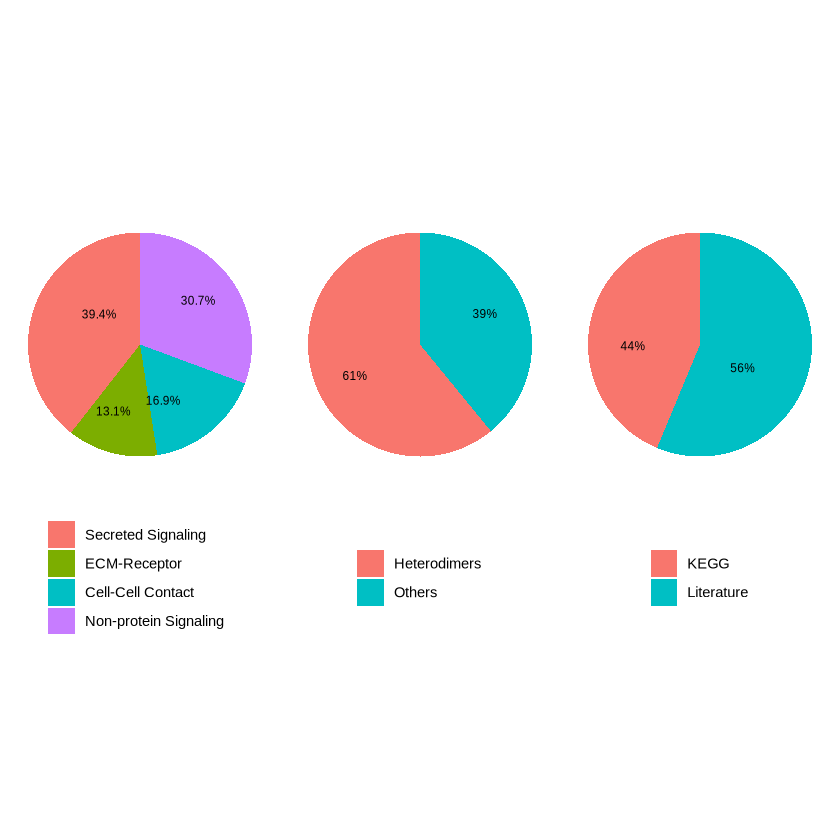

In [1]:
cell_chat_prediction = function(cellchat)
{
    cellchat <- setIdent(cellchat, ident.use = "annotation") # set "labels" as default cell identity
    levels(cellchat@idents) # show factor levels of the cell labels
    groupSize <- as.numeric(table(cellchat@idents)) # number of cells in each cell group

    # set the ligand-receptor interaction database
    CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
    showDatabaseCategory(CellChatDB)

    dplyr::glimpse(CellChatDB$interaction)

    # use a subset of CellChatDB for cell-cell communication analysis
    #CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") # use Secreted Signaling
    # use all CellChatDB for cell-cell communication analysis
    CellChatDB.use <- CellChatDB # simply use the default CellChatDB

    # set the used database in the object
    cellchat@DB <- CellChatDB.use

    cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
    future::plan("multisession", workers = 8) # do parallel
    options(future.globals.maxSize = 2000 * 10000000^2)  # Setting limit to 2 GiB

    cellchat <- identifyOverExpressedGenes(cellchat)
    cellchat <- identifyOverExpressedInteractions(cellchat)

    cellchat <- computeCommunProb(cellchat, type = "triMean")
    cellchat <- filterCommunication(cellchat, min.cells = 10)
    cellchat <- computeCommunProbPathway(cellchat)
    cellchat <- aggregateNet(cellchat)
    
    return(cellchat)
}

# set the ligand-receptor interaction database
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)
dplyr::glimpse(CellChatDB$interaction)

# use a subset of CellChatDB for cell-cell communication analysis
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") # use Secreted Signaling

# read the matrix
matrix = readMM("../Result/R_conversion/integrated_matrix.mtx")

# read the cell and gene names
cell_name = read.csv("../Result/R_conversion/cell_names.csv")
feature_name = read.csv("../Result/R_conversion/gene_names.csv")

# attached the gene and cells to the matrix
rownames(matrix) = cell_name$X0
colnames(matrix) = feature_name$X0

In [2]:
# read the meta
meta_info = read.csv("../Result/R_conversion/meta_info.csv")

data = CreateSeuratObject(counts = t(matrix), project = "pbmc3k", min.cells = 0, min.features = 0)

# add the meta information
for (i in meta_info){
    for (i in colnames(meta_info)){
        data[[i]] = meta_info[[i]]
    }
}

# add the new levels
# add new trait
meta = data@meta.data
meta <- meta %>%
  mutate(new_level = case_when(
    diagnosis == "control" ~ "Control",
    diagnosis %in% c("moderate", "advanced") ~ "Moderate",
    diagnosis == "severe" ~ "Severe",
    TRUE ~ "Unknown"  # Fallback for any other unexpected values
  ))
data@meta.data = meta

In [ ]:
# separate them into different groups
for (i in c("Control", "Moderate", "Severe"))
{
    tmp = subset(data, subset = new_level == i)
    count = tmp@assays$RNA@counts
    meta = tmp@meta.data
    cellchat <- createCellChat(object = count, meta = meta, group.by = "annotation")
    cellchat = cell_chat_prediction(cellchat)
    
    assign(paste0(i, "_cell_chat"), cellchat)
    print(i)
}

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  L1, L2/3, L4, L5, L6, WM 
Rows: 3,249
Columns: 28
$ interaction_name         <chr> "TGFB1_TGFBR1_TGFBR2", "TGFB2_TGFBR1_TGFBR2",…
$ pathway_name             <chr> "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TGFb…
$ ligand                   <chr> "TGFB1", "TGFB2", "TGFB3", "TGFB1", "TGFB1", …
$ receptor                 <chr> "TGFbR1_R2", "TGFbR1_R2", "TGFbR1_R2", "ACVR1…
$ agonist                  <chr> "TGFb agonist", "TGFb agonist", "TGFb agonist…
$ antagonist               <chr> "TGFb antagonist", "TGFb antagonist", "TGFb a…
$ co_A_receptor            <chr> "", "", "", "", "", "", "", "", "", "", "", "…
$ co_I_receptor            <chr> "TGFb inhibition receptor", "TGFb inhibition …
$ evidence                 <chr> "KEGG: hsa04350", "KEGG: hsa04350", "KEGG: hs…
$ annotation               <chr> "Secreted Signaling", "Secreted Signaling", "…
$ i

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”


The number of highly variable ligand-receptor pairs used for signaling inference is 2666 
triMean is used for calculating the average gene expression per cell group. 


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”


[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-02-25 12:10:36.130532]"


In [6]:
control = readRDS("../Result/cell_cell_communication_cellchat/Controlcell_chat_new.RDS")
moderate = readRDS("../Result/cell_cell_communication_cellchat/Moderatecell_chat_new.RDS")
severe = readRDS("../Result/cell_cell_communication_cellchat/Severecell_chat_new.RDS")

In [7]:
cellchat = readRDS("../Result/cell_cell_communication_cellchat/Cellchat_new.RDS")

In [4]:
gg1 <- compareInteractions(cellchat, show.legend = F, group = c(1,2,3))
gg2 <- compareInteractions(cellchat, show.legend = F, group = c(1,2,3), measure = "weight")

In [7]:
pdf("../Result/Figures/Cell_cell_interactions/LR_strength.pdf", width=4, height=4)
gg2
dev.off()

png 
  2

In [42]:
# check the LR pairs numbers in different layers
# advanced as example
# Include both the communication in and out
LR_numbers = function(level)
{
    LR_total = c()

    for (i in colnames(cellchat@net[[level]]$count))
    {
        number = sum(cellchat@net[[level]]$count[i,]) + sum(cellchat@net[[level]]$count[,i]) - cellchat@net[[level]]$count[i,i]
        LR_total = c(LR_total, number)
    }
    return(LR_total)
}

LR_number_table = c()
for (i in c("control", "moderate", "severe"))
{
    LR_list = LR_numbers(i)
    LR_number_table = cbind(LR_number_table, LR_list)
}
LR_number_table = data.frame(LR_number_table)
colnames(LR_number_table) = c("control", "moderate", "severe")
LR_number_table$Layer = c("L1", "L2/3", "L4", "L5", "L6", "WM")


# change the wide table into long table
data_long <- data.frame(pivot_longer(LR_number_table, cols = -Layer, names_to = "condition", values_to = "value"))
data_long$condition <- factor(data_long$condition, levels = c("control", "moderate", "severe"))

# Create the line plot
pdf("../Result/Figures/Cell_cell_interactions/LR_numbers_total_each_layer.pdf", width = 6, height=4)
ggplot(data_long, aes(x = condition, y = value, group = Layer, color = Layer)) +
  geom_line() + # Draw lines
  geom_point() + # Add points
  theme_minimal() + # Use a minimal theme
  labs(title = "Value by Condition and Layer",
       x = "Condition",
       y = "Value") + 
  scale_color_brewer(palette = "Set1") + # Use a color palette for better distinction
  scale_color_manual(values = c("L6" = "#E41A1C", 
                                "L5" = "#377EB8", 
                                "L4" = "#4DAF4A", 
                                "L2/3" = "#984EA3", 
                                "L1" = "#FF7F00", 
                                "WM" = "#A65628"))
dev.off()

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


png 
  2

In [34]:
# control interactions
#pdf("control_cellchat.pdf", width=3, height=3)
groupSize <- as.numeric(table(control@idents))
pdf("../Result/Figures/Cell_cell_interactions/control_cellchat.pdf", width=6, height=6)
netVisual_circle(
    control@net$count, 
    #vertex.weight = groupSize, 
    weight.scale = T, 
    label.edge= T, 
    title.name = "Number of interactions"
)[1]
dev.off()

[[1]]
NULL

png 
  2

In [33]:
# moderate interactions
groupSize <- as.numeric(table(moderate@idents))
pdf("../Result/Figures/Cell_cell_interactions/moderate_cellchat.pdf", width=6, height=6)
netVisual_circle(
    moderate@net$count, 
    vertex.weight = groupSize, 
    weight.scale = T, 
    label.edge= T, 
    title.name = "Number of interactions"
)[1]
dev.off()

[[1]]
NULL

png 
  2

In [36]:
groupSize <- as.numeric(table(severe@idents))
pdf("../Result/Figures/Cell_cell_interactions/severe_cellchat.pdf", width=6, height=6)
netVisual_circle(
    severe@net$count, 
    vertex.weight = groupSize, 
    weight.scale = T, 
    label.edge= T, 
    title.name = "Number of interactions",
    #remove.isolate = TRUE
)[1]
dev.off()

[[1]]
NULL

png 
  2

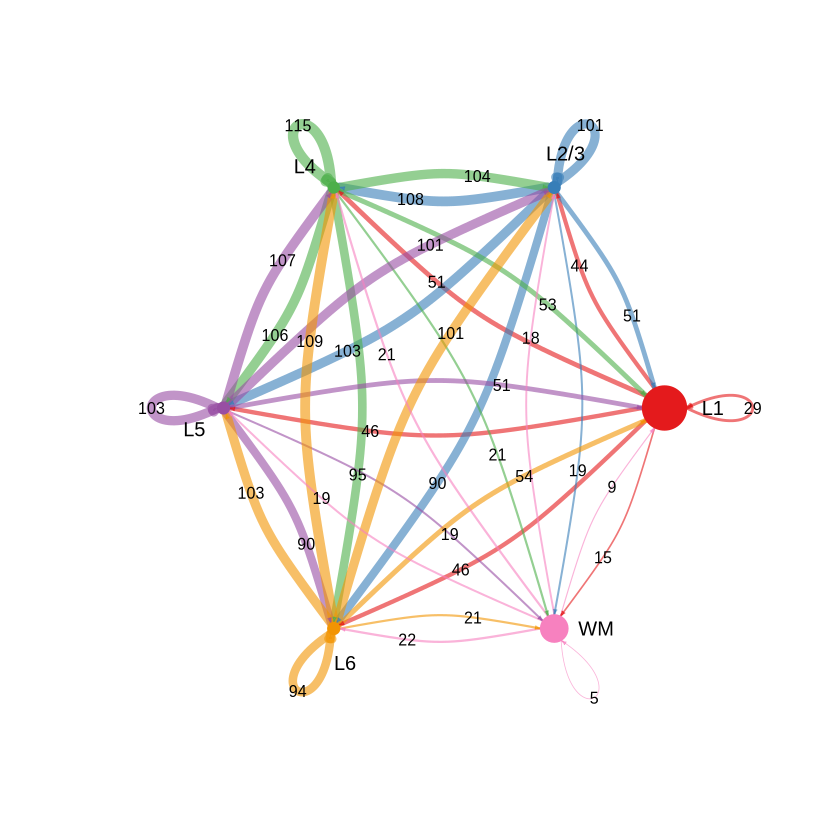

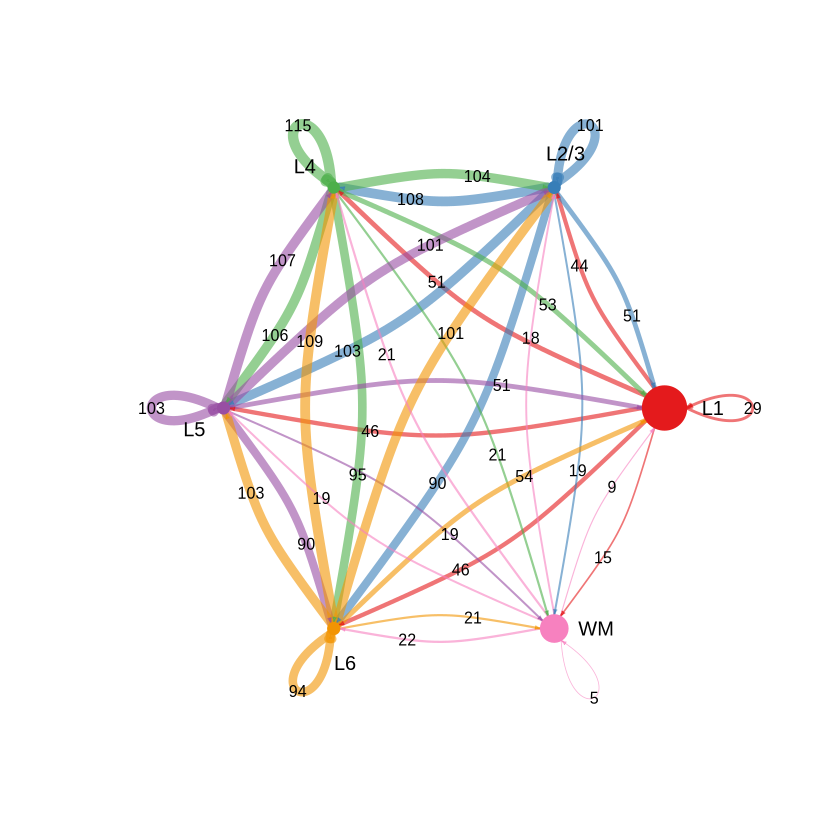

In [19]:
# control interactions
groupSize <- as.numeric(table(severe@idents))
netVisual_circle(
    severe@net$count, 
    vertex.weight = groupSize, 
    weight.scale = T, 
    label.edge= T, 
    title.name = "Number of interactions"
)

In [4]:
pdf("../Result/Figures/Cell_cell_interactions/moderate_to_control.pdf", width = 3, height = 3)
netVisual_heatmap(cellchat, color.heatmap = c("Blue","Red"), comparison = c(1,2))
dev.off()

Do heatmap based on a merged object 




png 
  2

In [14]:
pdf("../Result/Figures/Cell_cell_interactions/severe_to_moderate.pdf", width = 3, height = 3)
netVisual_heatmap(cellchat, color.heatmap = c("Blue","Red"), comparison = c(2,3))
dev.off()

Do heatmap based on a merged object 




png 
  2

In [8]:
pdf("../Result/Figures/Cell_cell_interactions/severe_to_control.pdf", width = 3, height = 3)
netVisual_heatmap(cellchat, color.heatmap = c("Blue","Red"), comparison = c(1,3))
dev.off()

Do heatmap based on a merged object 




png 
  2

In [45]:
pdf("../Result/Figures/Cell_cell_interactions/layer4_ligand-pairs.pdf", width = 5, height = 2)
netVisual_bubble(
    cellchat, 
    sources.use = 3, 
    targets.use = c(1:6),  
    comparison = c(1,2,3), 
    angle.x = 45,
    signaling = "APP"
)
dev.off()

Comparing communications on a merged object 




png 
  2

Comparing communications on a merged object 




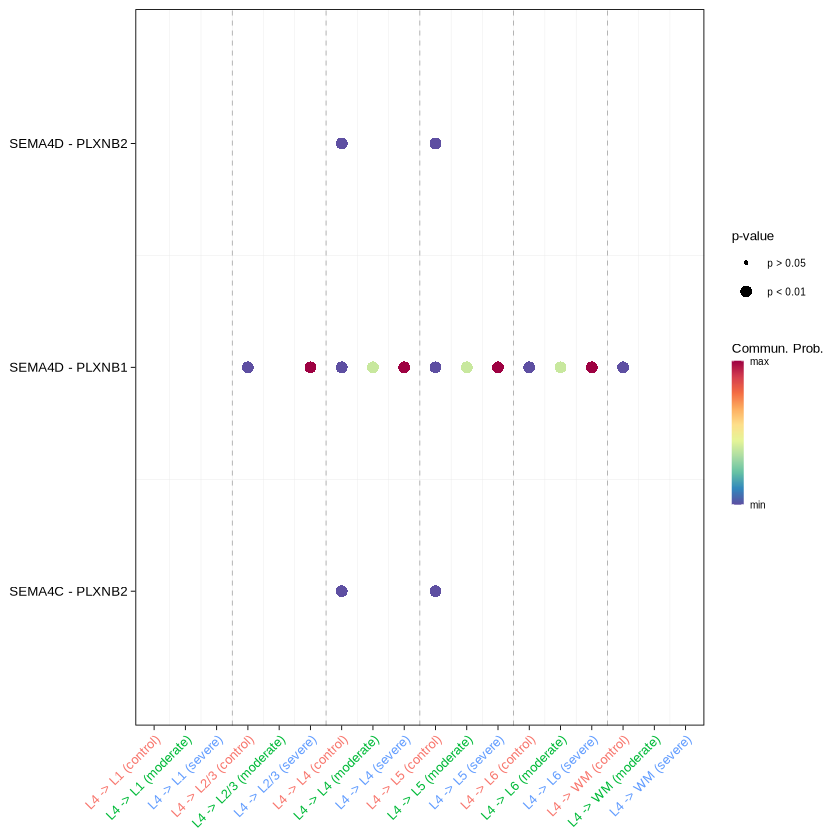

In [57]:
netVisual_bubble(
    cellchat, 
    sources.use = 3, 
    targets.use = c(1:6),  
    comparison = c(1,2,3), 
    angle.x = 45,
    signaling = "SEMA4"
)

In [48]:
cellchat@netP$severe

[1] "NRXN"        "Glutamate"   "ADGRL"       "NCAM"        "NEGR"       
 [6] "PTPR"        "GAP"         "NRG"         "CNTN"        "PSAP"       
[11] "CADM"        "Cholesterol" "PCDH"        "APP"         "CypA"       
[16] "UNC5"        "FLRT"        "PTN"         "FGF"         "CDH"        
[21] "NGL"         "GAS"         "EPHA"        "CLDN"        "ADGRG"      
[26] "TENASCIN"    "SLIT"        "PTPRM"       "SEMA4"       "ANGPTL"     
[31] "MAG"         "PECAM1"